In [1]:
import matplotlib.pyplot as plt

from scipy.stats import norm

##import matplotlib as mpl

import random
import time

#from numpy.random import multivariate_normal as mvn
from sklearn import mixture
from GMM_Conditional import *

In [2]:
def heston_qestep(Xt,Vt,sigma,vLong,kappa,rho,deltat,gamma1,gamma2,psiC):    
    #QE discretization Agorithm for the Return Process {Xt+1}, yield one step ahead return conditional on Vt and Xt
    # new variance
        k1 = np.exp(-kappa*deltat)
        k2 = sigma**2 * k1 * (1-k1)/kappa
        k3 = np.exp(kappa*deltat)*0.5*k2*(1-k1)*vLong
        
        m = vLong +(Vt - vLong) * k1
        s2 = Vt * k2 + k3
        psi = s2/m**2
        if psi <= psiC:
            b2 = 2/psi-1 + (2/psi*(2/psi-1))**0.5 
            a = m/(1+b2)
            Zv = norm.ppf(random.random())
            Vnew = a*(Zv + b2**0.5)**2     #Non central Chi square variable aproximate sufficiently big value of Vt
        elif psi > psiC:
            p = (psi-1)/(psi+1)
            #beta = 2/ (m+m*psi)           #Function of Delta Dirac variable for sufficiently small value of Vt
            beta = (1-p)/m
            Uv = random.random()
            if Uv <=p:
                Vnew=0
            elif Uv> p:
                Vnew = np.log((1-p)/(1-Uv)) / beta
        
        # variables for the predictor-corrector step
        K0 = -(rho*kappa*vLong)*deltat/sigma 
        K1 = gamma1*deltat*(-0.5+(kappa*rho/sigma))-(rho/sigma)
        K2 = gamma2*deltat*(-0.5+(kappa*rho/sigma))+(rho/sigma)
        K3 = gamma1*deltat*(1-rho**2)
        K4 = gamma2*deltat*(1-rho**2)
        Zv = norm.ppf(random.random())              # Gaussian N(0,1)
        # predictor-corrector step
        Xnew = Xt + (r- q) * deltat + K0 + K1 * Vt + K2 * Vnew + ((K3 * Vt + K4 * Vnew)**0.5) * Zv
        return [Xnew,Vnew]


def heston_qe(S,v0,sigma,vLong,kappa,rho,T,NSim,NT):
    gamma1 = 0.5 #averaging factors for the discretivazion of Xt
    gamma2 = 0.5 #averaging factors for the discretivazion of Xt
    psiC = 1.5   #Threshold for the initiation of the two aproximate distribution of V(t+1 | Vt)
        
    Nt = NT+1    # index 0 keeps the current values for S and V   
    deltat = T/NT
        
    # stores the paths
    pathS = np.zeros([NSim,Nt])
    pathV = np.zeros([NSim,Nt])
    pathS[:,0] = S
    pathV[:,0] = v0

    for i in range(NSim):
        Snew = np.log(S*np.exp(-q*T))
        Vnew = v0
        #print(Nt)
        for j in range(NT): 
            new = heston_qestep(Snew,Vnew,sigma,vLong,kappa,rho,deltat,gamma1,gamma2,psiC) 
               
            Snew = new[0] 
            Vnew = new[1]

            pathS[i,j+1] = np.exp(Snew)
            pathV[i,j+1] = Vnew
    
    return pathS, pathV

In [3]:
# binning method from Oosterlee et al. for SLV calibration
# this is used to calculate E[Vt|St=s], we use method (3.8) from the paper

def expectationBin(nbins, nsims, array_in): #, expect_var):   
    # nbins    - number of bins
    # nsims    - number of simulations
    # array_in - pairs (x, v) of size nsims x 2, this array is sorted wrt axis = 0
    
    
    alphak = 1. / nbins # fomula for bin eq (3.8)

    expect_var = np.zeros(nsims)
    
    denum = nsims/nbins
    
    # create a list with the indizes that consitute the values for bin bounds
    ii = []
    ii.append(0)
    # construct the bins that approximately nsims/nbins elements are in each bin
    for j in range(1,nbins):
        index = int(j * denum)
        ii.append(index)
    ii.append(nsims)
    
    
    # check later if we need index - 1
    for k in range(nbins):
        if k == 0:
            index1 = 0
        else:
            index1 = ii[k]-1
        if k == nbins:
            index2 = -1
        else:
            index2 = ii[k+1] - 1

        expect_var[index1:index2] = np.sum(array_in[index1:index2,1]) / (alphak * nsims) #expect_bin[k]
        expect_var[-1] = expect_var[-2]

    return expect_var

In [4]:
# Heston parameters
S0 = 100.0        # spot asset
Nsim = 10000      # number of simulations

K = 95            # strike price
r = 0.01          # rate
q = 0.0           # continuous dividend yield
v0 = 0.3**2       # spot variance
vLong = 0.32**2   # long term variance
kappa = 0.2       # reversion rate for variance
sigma = 0.3       # volatility of variance
rho = -0.5        # correlation of BM for asset and variance

feller = 2 * kappa * vLong/sigma**2

time_grid = np.array([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

idx_T = -1            # index on time grid T
idx_t = -2            # index on time grid t, -2 corresponds to .9, -6 to .5
T = time_grid[idx_T]  # get the time for T from grid
t = time_grid[idx_t]  # get the time for t from grid
df = np.exp(-r*(T-t)) # discount factor 

Nt = 10               #

# run Heston simulation
np.random.seed(0)                                       # random seed
S, V = heston_qe(S0,v0,sigma,vLong,kappa,rho,T,Nsim,Nt) # simulate and store S and V

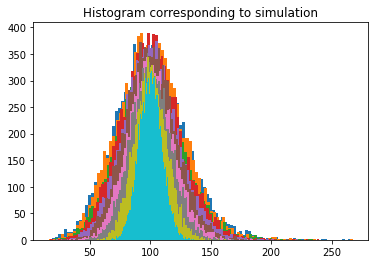

267.521971451319 15.939251184211807 0.4551111111111112


In [5]:
# plot histograms for the grid
plt.figure()
nbins = 100                   # number of bins used
ir = len(time_grid)
for j in range(0,ir-1):
    plt.hist(S[:,-(j+1)],nbins)
plt.title('Histogram corresponding to simulation')
plt.show()



print(np.max(S), np.min(S), feller)     # minimal and maximal values and feller condition

In [6]:
Vt = V[:,idx_t]               # variance at time t
VT = V[:,idx_T]               # variance at time T

St = S[:,idx_t]               # spot at time t
ST = S[:,idx_T]               # spot at time T

Ot = np.maximum(St-K,0.)      # option value at time t
OT = df * np.maximum(ST-K,0.) # option value at time T discounted to t

min_idx_t = np.min(St)
max_idx_t = np.max(St)

print("min value at" + str(idx_t) + " is " + str(np.min(St)))
print("max value at" + str(idx_t) + " is " + str(np.max(St)))

min value at-2 is 15.939251184211807
max value at-2 is 267.521971451319


(15.939251184211807, 267.521971451319)

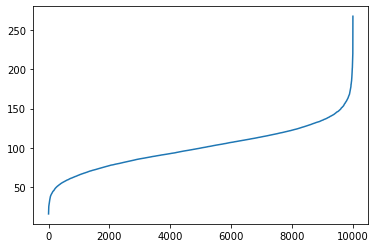

In [7]:
Splot = St
plt.plot(np.sort(Splot))
np.min(Splot), np.max(Splot)

In [8]:
#Srange = np.linspace(20,180,1000)
Srange = np.linspace(min_idx_t,max_idx_t,1000)

In [9]:
#### conditional variance with binning starts

In [10]:
SortArray = np.zeros((Nsim,2))
expect_var = np.ones(Nsim) * v0

v = np.zeros((Nt, Nsim))            # values of the variance
x = np.zeros((Nt, Nsim))            # values of the asset
condvar = np.zeros((Nt,Nsim))

v[0, :] = v0
x[0, :] = np.log(S0)
condvar[0,:] = v0

nbins = 50

lS = np.log(S)

# sort the wrt to s values but keep the v values to its initial s value
for i in range(Nt-1):
    index = np.argsort(lS[:,i+1])
    x[i+1,:] = lS[index,i+1]
    v[i+1,:] = V[index, i+1]
            
    SortArray[:, 0] = x[i+1,:]
    SortArray[:, 1] = v[i+1,:]

    # use the binning method on Sort Array
    expect_var = expectationBin(nbins, Nsim, SortArray)
    # the expected variance can be zero due to no realization was
    # generated in a region. Then, we set expect_var to a small value
    # not sure what to choose best
    expect_var[expect_var <= 0.] = np.min(expect_var[expect_var > 0.])
    condvar[i+1,:] = expect_var

# x and v contain now the sorted values of asset and corresponding to the asset ordering
# the v values at each time point, i.e. x[i,k] <= x[i,k+1] but v[i,k] <= v[i,k+1] must not hold!!!

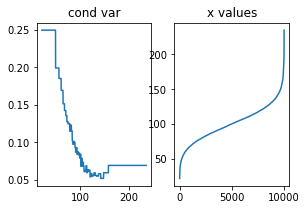

In [11]:
# plot the result from binning and the sorted asset values
St_sorted = np.exp(x[idx_t,:])
Vt_sorted = v[idx_t,:]

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='cond var')
plt.plot(St_sorted, condvar[idx_t,:])
ax = fig.add_subplot(132, title='x values')
plt.plot(St_sorted)

In [12]:
# fit a Gaussian and calculate the conditional expectation analytically
# for the conditioning on the variance
# this is the slv case

ngmm = 5                                # number of mixture distributions

start = time.time()
X_condvar = np.vstack((Vt,St)).T        # set up the training set
gmm_v = mixture.GaussianMixture(n_components=ngmm).fit(X_condvar)

gmm_cond_v = GMM_Conditional(means=gmm_v.means_,
                           covariances=gmm_v.covariances_,
                           weights=gmm_v.weights_,
                           n_components=gmm_v.n_components,
                           D1=1, D2=1)

exvar = []

# use the x values computed above
for j in range(Nsim):
    output = gmm_cond_v.mu_x1_cond_x2(St_sorted[j])
    exvar.append(output)                                

end = time.time()
time_simple = end-start
print(time_simple)

1.5139257907867432


43.76876529292347 166.78852851465626


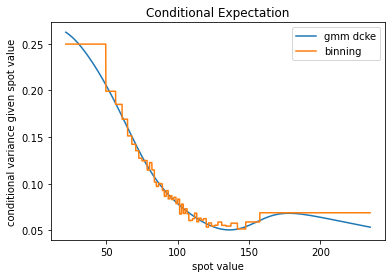

In [13]:
# plot the results comparing GMM-DCKE with binning method
plt.plot(St_sorted, np.maximum(exvar,0.), label = "gmm dcke")
plt.plot(St_sorted, condvar[idx_t,:], label = "binning")
plt.legend()
plt.title("Conditional Expectation")
plt.xlabel("spot value")
plt.ylabel("conditional variance given spot value")

print(np.quantile(St_sorted,.01), np.quantile(St_sorted,.99))

In [14]:
# gmm dcke with different number for K to fit GMM(K)
ngmm_list = [1,2,3,4,5,7] 

X_condvar = np.vstack((Vt,St)).T        # set up the training set
eexvar = []

for ngmm in ngmm_list:
    # run through all values for K
    gmm_v = mixture.GaussianMixture(n_components=ngmm).fit(X_condvar)

    gmm_cond_v = GMM_Conditional(means=gmm_v.means_,
                           covariances=gmm_v.covariances_,
                           weights=gmm_v.weights_,
                           n_components=gmm_v.n_components,
                           D1=1, D2=1)

    exvar = []

    # use the x values computed above
    for j in range(Nsim):
        output = gmm_cond_v.mu_x1_cond_x2(St_sorted[j])
        exvar.append(output)
    eexvar.append(np.asarray(exvar))

0.01 -quantile 43.76876529292347 ; 0.99 -quantile 166.78852851465626


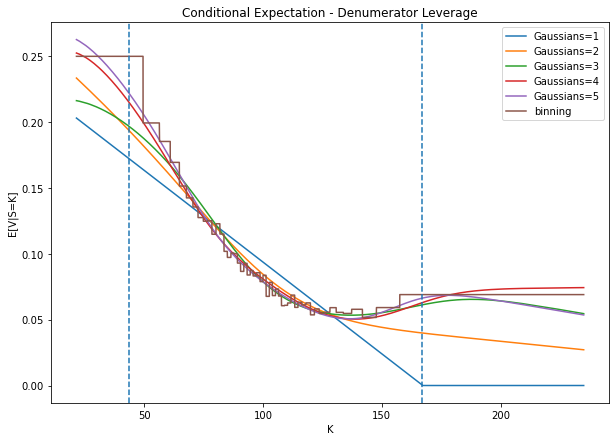

In [15]:
# plot the results for gmm dcke vs binning
fig, ax = plt.subplots(figsize=(10,7))
for n in range(1,len(ngmm_list)):
    ax.plot(St_sorted, np.maximum(eexvar[n-1],0.), label= "Gaussians="+ str(n))
ax.plot(St_sorted, condvar[idx_t,:], label='binning')

#ngmm_list.append('binning')

ax.title.set_text("Conditional Expectation - Denumerator Leverage")
ax.set(xlabel = 'K', ylabel = 'E[V|S=K]')
ax.legend()
lq = 0.01
uq = 0.99
print(lq,"-quantile", np.quantile(St_sorted,.01),";",uq,"-quantile", np.quantile(St_sorted,.99))
plt.axvline(x=np.quantile(St_sorted,lq), linestyle="--", label = "quantile " + str(lq))
plt.axvline(x=np.quantile(St_sorted,uq), linestyle="--", label = "quantile " + str(uq))

#fig.savefig('gmm-dcke_slv_binning_heston.pdf')

plt.show()



0.005 -quantile 38.91492999554228 ; 0.995 -quantile 181.57565425821372
0.01 -quantile 43.76876529292347 ; 0.99 -quantile 166.78852851465626
0.05 -quantile 59.236799191611304 ; 0.95 -quantile 144.4219585355226
0.1 -quantile 67.78614964746419 ; 0.9 -quantile 133.8183794698838


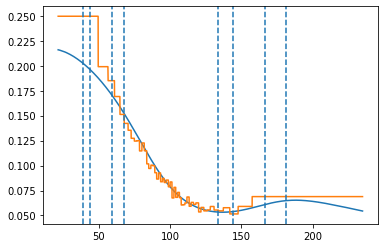

In [16]:
# plot the results gmm-dcke vs binning for different quantiles
plt.plot(St_sorted, np.maximum(eexvar[2],0.))
plt.plot(St_sorted, condvar[idx_t,:])

quantile_list = [0.005, 0.01, 0.05, 0.1]
for q in quantile_list:
    plt.axvline(x=np.quantile(St_sorted,q), linestyle="--")
    plt.axvline(x=np.quantile(St_sorted,1-q), linestyle="--")    
    print(q,"-quantile", np.quantile(St_sorted,q),";", 1- q,"-quantile", np.quantile(St_sorted,1-q))

In [17]:
### gmm dcke enhanced with bagging
nbags = 20       # number of bags
Nsim_bag = 500  # size of training set per simulation

nbins = 50

sbag = []
gbag = []
St_sorted_bag = []
Vt_sorted_bag = []

ngmm = 3                                # number of mixture distributions

fulltime = 0.

start = time.time()

for n in range(nbags):
    start1 = time.time()
    SortArray_bag = np.zeros((Nsim_bag,2))
    expect_var_bag = np.ones(Nsim_bag) * v0

    v_bag = np.zeros((Nt, Nsim_bag))            # values of the variance
    x_bag = np.zeros((Nt, Nsim_bag))            # values of the asset
    condvar_bag = np.zeros((Nt,Nsim_bag))
    
    idx = np.random.choice(range(Nsim),Nsim_bag)# select the elements in bag with replacement
    #random.sample(range(Nsim), Nsim_bag)       # select the elements in bag without replacement
    S_bag = S[idx,:]                            # init the training set for S
    V_bag = V[idx,:]                            # init the training set for V
    
    lS_bag = np.log(S_bag)
    
    v_bag[0, :] = v0
    x_bag[0, :] = np.log(S0)
    condvar_bag[0,:] = v0
    

    # sort the wrt to s values but keep the v values to its initial s value
    for i in range(Nt-1):
        index = np.argsort(lS_bag[:,i+1])
        x_bag[i+1,:] = lS_bag[index,i+1]
        v_bag[i+1,:] = V_bag[index,i+1]
            
        SortArray_bag[:, 0] = x_bag[i+1,:]
        SortArray_bag[:, 1] = v_bag[i+1,:]

        # use the binning method on Sort Array
        expect_var_bag = expectationBin(nbins, Nsim_bag, SortArray_bag)
        # the expected variance can be zero due to no realization was
        # generated in a region. Then, we set expect_var to a small value
        # not sure what to choose best
        expect_var_bag[expect_var_bag <= 0.] = np.min(expect_var_bag[expect_var_bag > 0.])
        condvar_bag[i+1,:] = expect_var_bag
    
    end1 = time.time()
    fulltime = fulltime + end1-start1
    
    s_s_bag = np.exp(x_bag[idx_t,:])
    v_s_bag = v_bag[idx_t,:]
    St_sorted_bag.append(s_s_bag)
    Vt_sorted_bag.append(v_s_bag)  
    
    sbag.append(condvar_bag)

    X_condvar_bag = np.vstack((v_s_bag,s_s_bag)).T        # set up the training set
    gmm_v_bag = mixture.GaussianMixture(n_components=ngmm).fit(X_condvar_bag)

    gmm_cond_v_bag = GMM_Conditional(means=gmm_v_bag.means_,
                           covariances=gmm_v_bag.covariances_,
                           weights=gmm_v_bag.weights_,
                           n_components=gmm_v_bag.n_components,
                           D1=1, D2=1)

    exvar_bag = []

    # use the x values computed above
    for j in range(Nsim_bag):
        exvar_bag.append(gmm_cond_v_bag.mu_x1_cond_x2(s_s_bag[j]))                 
    gbag.append(np.asarray(exvar_bag))
    
end = time.time()
time_bag = end - start - fulltime
print(time_bag)

1.130035161972046


In [18]:
print(time_simple / time_bag)

1.3397156493296742


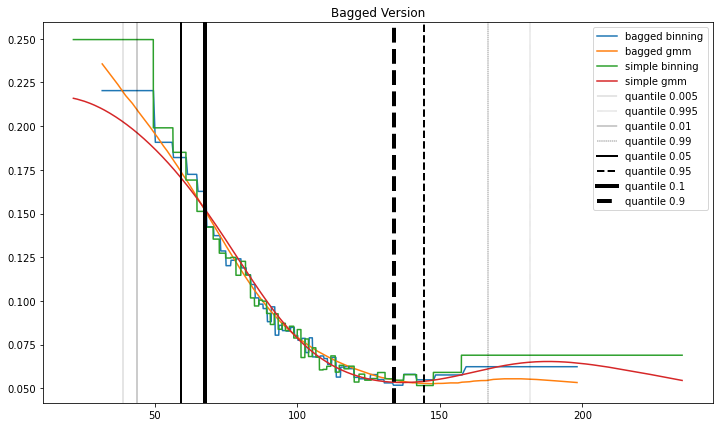

In [19]:
# plot the result from binning and the sorted asset values
#plt.plot(np.mean(St_sorted_bag), np.mean(sbag[:][idx_t,:]))
ss_sorted_bag = np.mean(St_sorted_bag, axis = 0)
ssbag = np.mean(sbag, axis = 0)

quantile_list = [0.005, 0.01, 0.05, 0.1]

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(ss_sorted_bag, ssbag[idx_t,:], label = "bagged binning")
ax.plot(ss_sorted_bag, np.mean(np.asarray(gbag)[:,:,0], axis = 0), label = "bagged gmm")
ax.plot(St_sorted, condvar[idx_t,:], label = "simple binning")
ax.plot(St_sorted, np.maximum(eexvar[2],0.), label='simple gmm')
for q in quantile_list:
    plt.axvline(x=np.quantile(St_sorted,q), linestyle="-", c = 'black', lw = q*40, label = "quantile " + str(q))
    plt.axvline(x=np.quantile(St_sorted,1-q), linestyle="--", c = 'black', lw = q * 40, label = "quantile " + str(1-q))
plt.title("Bagged Version")
plt.legend()

#plt.savefig('gmm-dcke_bagging_heston.pdf')

plt.show()




(-0.05, 0.05)

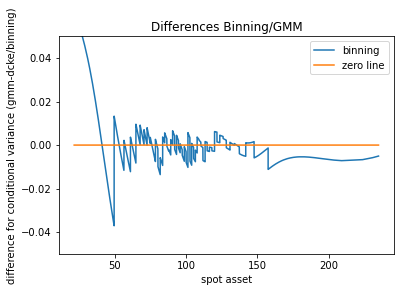

In [20]:
# plot the differences for gmm dcke and binning
vvv = np.transpose(np.array(exvar))
yyy = np.transpose(np.asarray(condvar[idx_t,:]))
vvv = np.array(vvv[0] - yyy)
plt.plot(St_sorted, np.array(vvv), label="binning")
plt.plot(St_sorted, np.zeros_like(vvv), label = "zero line")
plt.title("Differences Binning/GMM")
plt.legend()
plt.xlabel("spot asset")
plt.ylabel("difference for conditional variance (gmm-dcke/binning)")
plt.ylim(-0.05, 0.05)

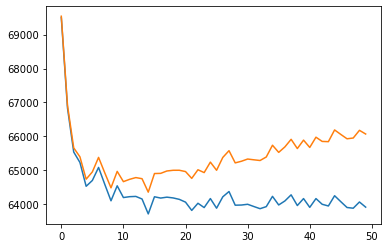

In [21]:
# calculate aic and bic for different number of mixtures
plot = 1

if plot == 1:
    X_condvar = np.vstack((Vt,St)).T

    nc = range(50)

    aic = []
    bic = []
    for i in nc:
        gmm_v = mixture.GaussianMixture(n_components=i+1).fit(X_condvar)

        aic.append(gmm_v.aic(X_condvar))
        bic.append(gmm_v.bic(X_condvar))
    
    plt.plot(aic)
    plt.plot(bic)
# determine the 
if plot == 1:
    index = np.where(bic == np.min(bic))
    index[0][0]
    
# the plot can serve as an indicator for the number of components using the "gradient" method
# respectively the value for aic or bic being minimal